In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore") # Just ignoring some Tensor flow / Keras Warnings


In [2]:
image_size = 256
batch_size = 36
epochs = 75
channels = 3
directory = "C:\\Users\\User\\TensorFlowFruits\\images"

In [3]:
dataset = tf.keras.utils.image_dataset_from_directory(
    directory,
    shuffle=True,
    image_size = (image_size,image_size)
)

Found 1192 files belonging to 9 classes.


In [4]:
class_names = dataset.class_names
class_names[7]

'orange fruit'

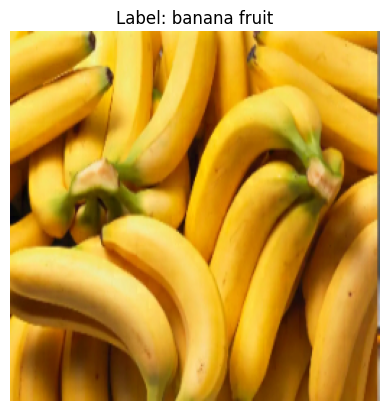

In [5]:
image_batch, label_batch = next(iter(dataset.take(1)))

plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.title("Label: {}".format(class_names[label_batch[0].numpy()]))
plt.axis("off")
plt.show()

# Spliting dataset

* 75% = Training
* 25% = 15% Validation, 10% Test

In [6]:
train_size = 0.75
train = int(len(dataset)*train_size)
train_ds = dataset.take(train)

In [7]:
test_ds = dataset.skip(train)

In [8]:
val_size = 0.15
val = int(len(dataset)*val_size)
val_ds = test_ds.take(val)

In [9]:
test_ds = test_ds.skip(val)

In [10]:
def get_df_partitions(ds, train_split=0.75,val_split=0.15, test_split=0.1, shuffle=True,shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=166)
    
    train_size = int(ds_size * train_split)
    val_size = int(ds_size * val_split)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [11]:
train_ds, val_ds, test_ds = get_df_partitions(dataset)

# Cache & Prefet Dataset

In [12]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building Our Model

## Creating Augmentation and Resize/Rescale Layers
Before we start our model, we need to preprocess our input images. First, we have to ensure that all images are the same size. Then, to enhance our training, we use augmentation techniques to flip our images, adjust saturation, and zoom.

In [13]:
# Doing Rescaling to normalize the color channels, so we divide by 255 and Resize to make every image the same size 256 x 256

resize_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255),
])

In [14]:
# Doing random zoom and random contrast, I need to see more about the hyperparameters now, this layers don't improve my accuracy
# and kind of kill my neural network

zoom_contrast = tf.keras.Sequential([
    layers.RandomZoom(height_factor=(0.1, 0.3), width_factor=(0.1, 0.3)),  
    layers.RandomContrast(factor=(0.1, 0.3))
])

In [15]:
# Augmentation for multiply our training samples

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

We just applied Data Augmentation to our model, based on rotation and flip. We could also incorporate zoom and contrast adjustments, similar to the 'zoom_contrast' layer constructed above. However, integrating these features would require additional effort, which could potentially enhance our model's performance. 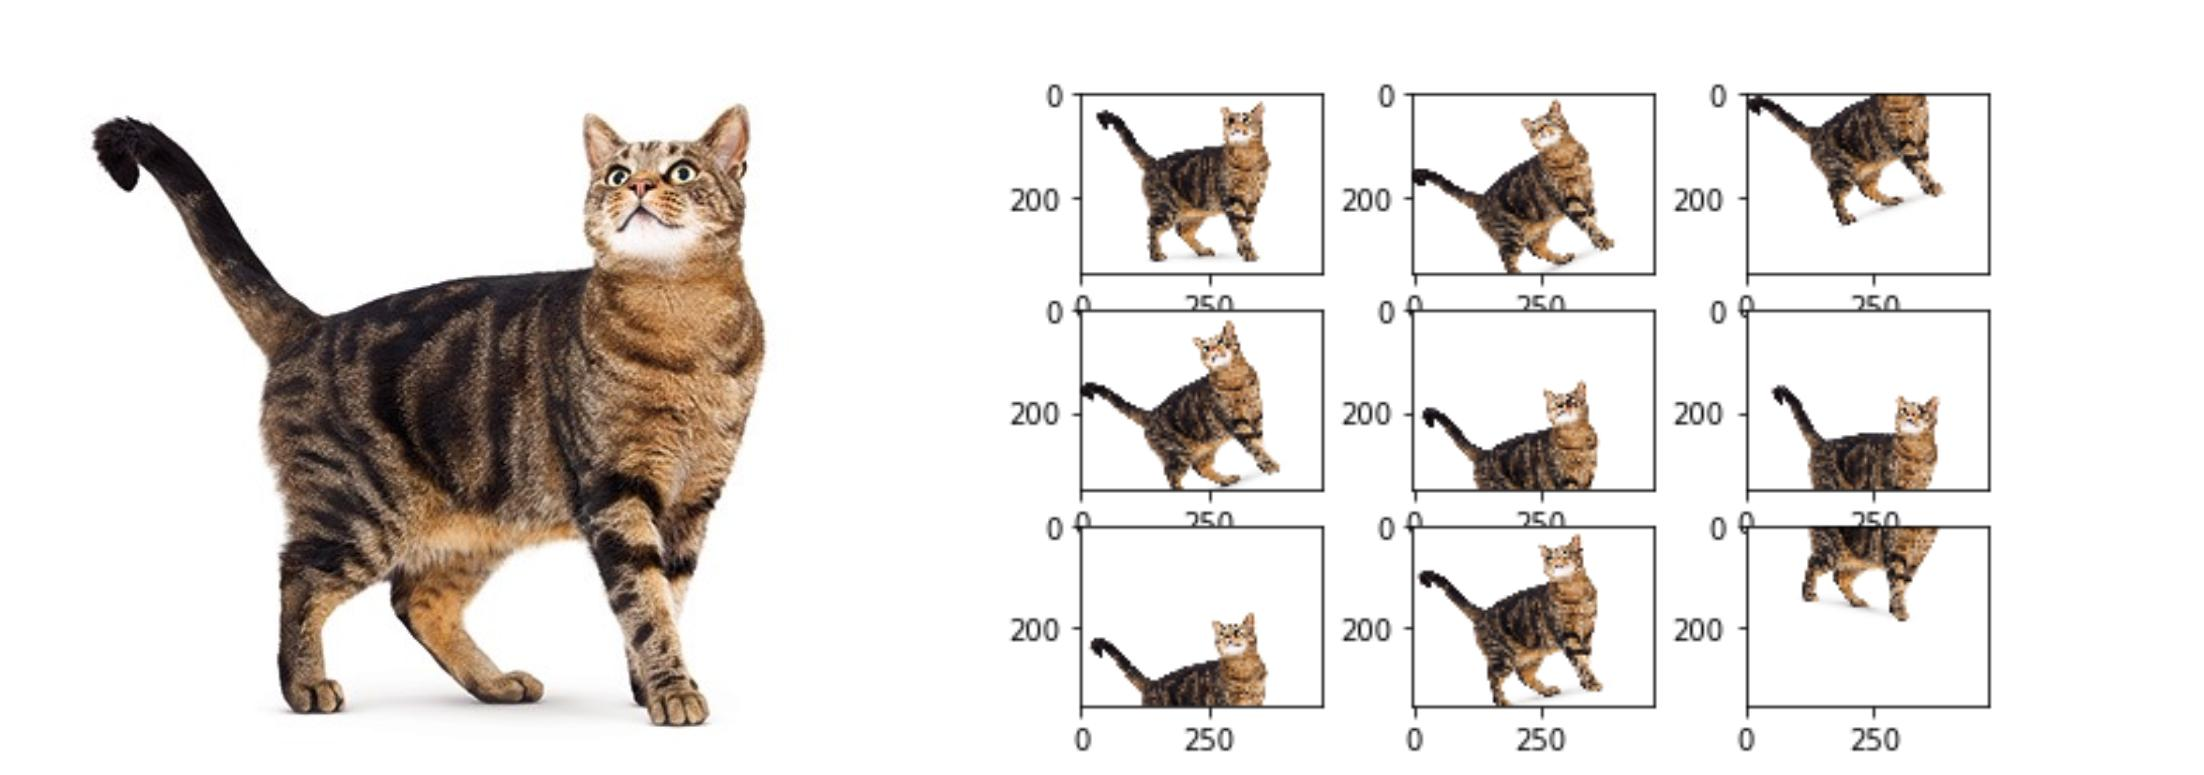

## Model Architecture

We used the CNN architecture, which is great for image classification, and also applied some techniques to improve our model. 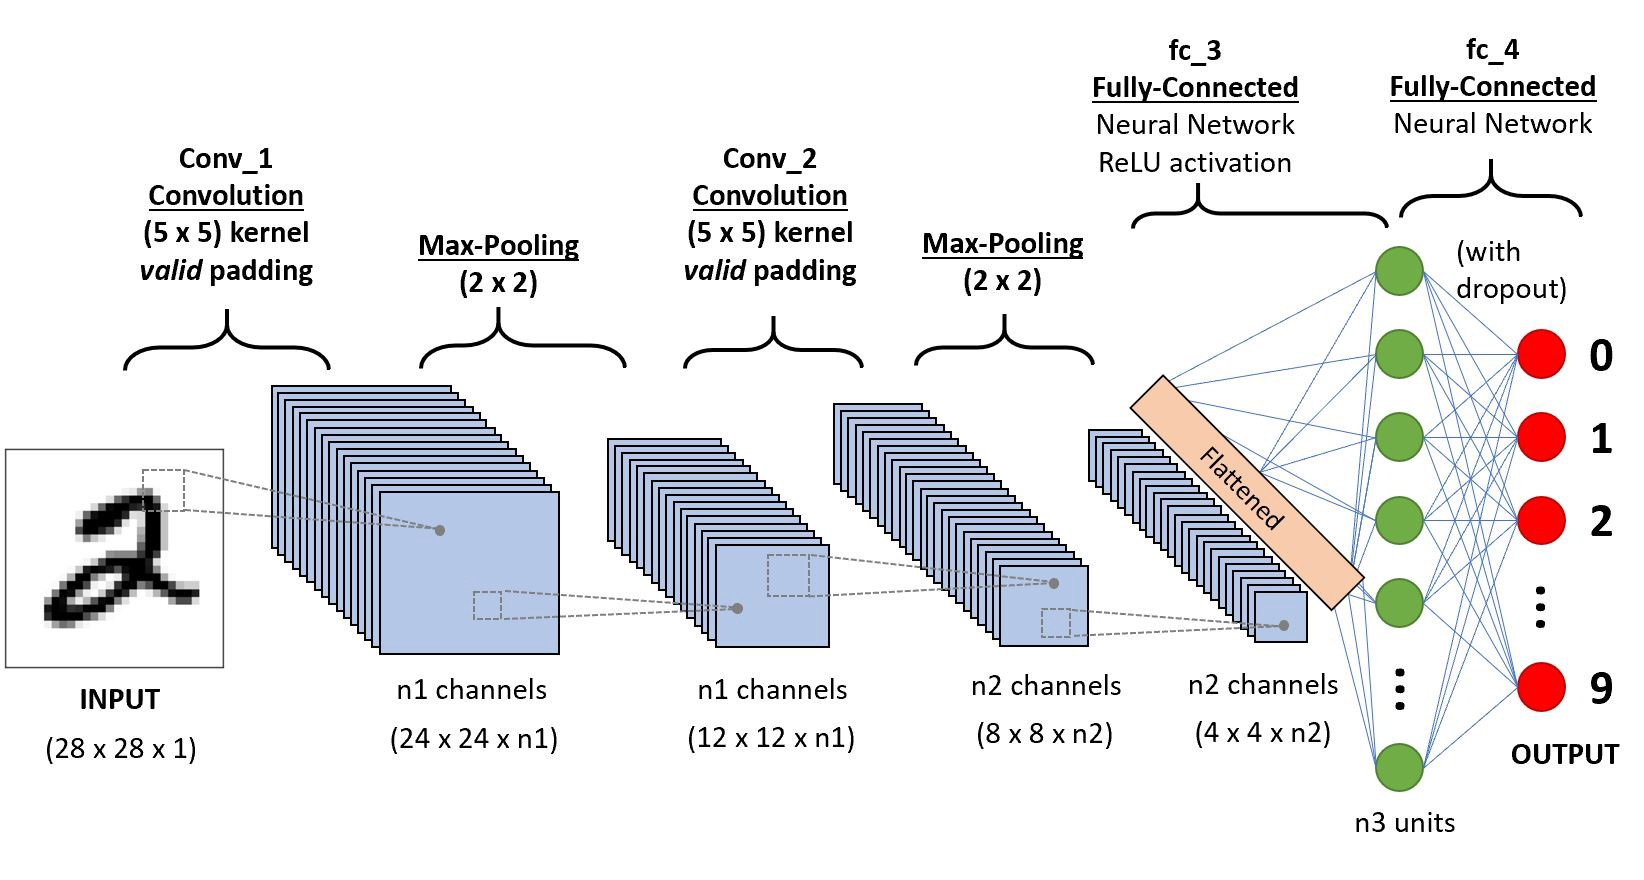

In [16]:
input_shape = (batch_size,image_size,image_size, channels)
dropout_rate = 0.6
regularizer = 0.01
n_classes = len(class_names)

model = tf.keras.Sequential([
    resize_rescale,
    data_augmentation,
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(rate=dropout_rate),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])


Using Dropout with a rate of 0.5 means that when the epoch runs, 50% of the neurons in the dropout layer will be randomly lost. This helps keep our model away from overfitting. 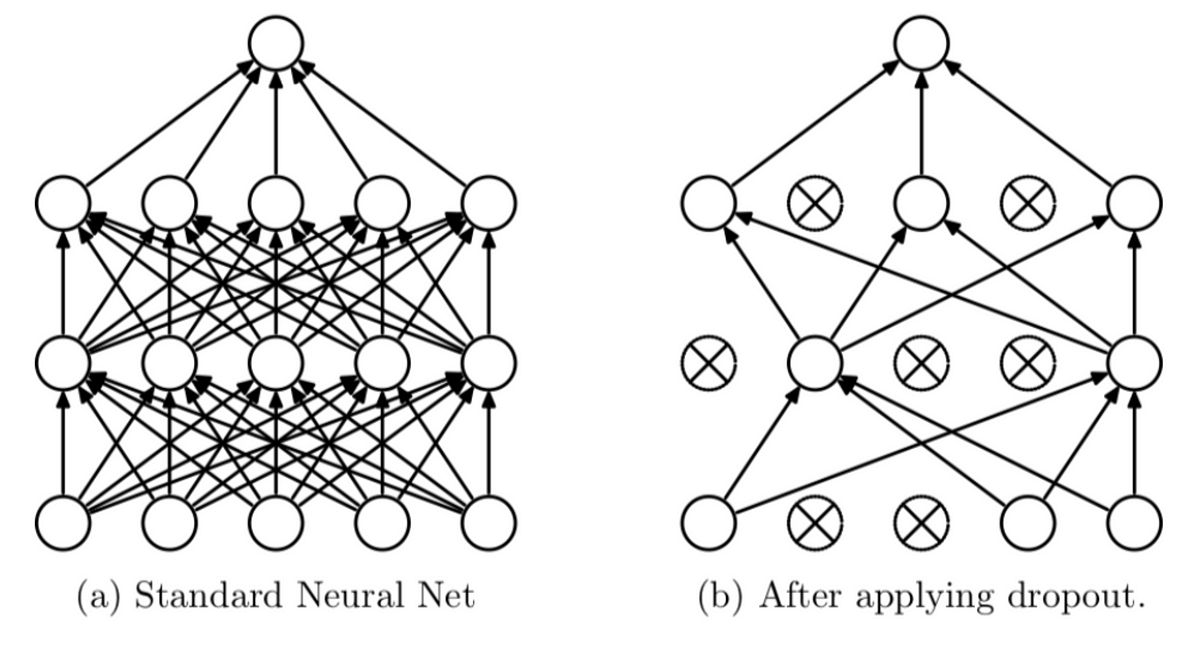

In [17]:
model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (36, 256, 256, 3)         0         
                                                                 
 sequential_2 (Sequential)   (36, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (36, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (36, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (36, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (36, 62, 62, 64)          0         
 g2D)                                                 

## Applying Data PreProcess on Train Dataset

In [18]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Compile

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [21]:
history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/75


28/28 [==============================] - 33s 1s/step - loss: 2.2020 - accuracy: 0.1055 - val_loss: 2.1962 - val_accuracy: 0.1000
Epoch 2/75
28/28 [==============================] - 25s 898ms/step - loss: 2.0812 - accuracy: 0.1961 - val_loss: 1.9406 - val_accuracy: 0.2250
Epoch 3/75
28/28 [==============================] - 26s 909ms/step - loss: 1.8421 - accuracy: 0.2110 - val_loss: 1.6779 - val_accuracy: 0.3125
Epoch 4/75
28/28 [==============================] - 27s 962ms/step - loss: 1.6583 - accuracy: 0.3062 - val_loss: 1.7117 - val_accuracy: 0.2812
Epoch 5/75
28/28 [==============================] - 27s 946ms/step - loss: 1.6059 - accuracy: 0.3440 - val_loss: 1.4593 - val_accuracy: 0.3562
Epoch 6/75
28/28 [==============================] - 27s 968ms/step - loss: 1.4932 - accuracy: 0.3796 - val_loss: 1.3262 - val_accuracy: 0.4187
Epoch 7/75
28/28 [==============================] - 27s 978ms/step - loss: 1.4202 - accuracy: 0.4404 - val_loss: 1.3428 - val_accuracy: 0.4938


Epoch 55/75
28/28 [==============================] - 21s 733ms/step - loss: 0.4830 - accuracy: 0.8303 - val_loss: 0.5161 - val_accuracy: 0.8250
Epoch 56/75
28/28 [==============================] - 22s 769ms/step - loss: 0.4229 - accuracy: 0.8486 - val_loss: 0.5315 - val_accuracy: 0.8687
Epoch 57/75
28/28 [==============================] - 21s 755ms/step - loss: 0.4428 - accuracy: 0.8417 - val_loss: 0.5090 - val_accuracy: 0.8625
Epoch 58/75
28/28 [==============================] - 21s 773ms/step - loss: 0.4453 - accuracy: 0.8326 - val_loss: 0.4870 - val_accuracy: 0.8750
Epoch 59/75
28/28 [==============================] - 21s 762ms/step - loss: 0.4737 - accuracy: 0.8394 - val_loss: 0.5371 - val_accuracy: 0.8313
Epoch 60/75
28/28 [==============================] - 21s 738ms/step - loss: 0.4845 - accuracy: 0.8337 - val_loss: 0.5290 - val_accuracy: 0.8500
Epoch 61/75
28/28 [==============================] - 20s 749ms/step - loss: 0.4246 - accuracy: 0.8521 - val_loss: 0.4510 - val_accuracy:

In [22]:
scores = model.evaluate(test_ds)

5/5 [==============================] - 3s 146ms/step - loss: 0.4534 - accuracy: 0.8562


In [23]:
scores

[0.45343217253685, 0.856249988079071]

# Ploting Acurracy and loss

When the training accuracy line keeps increasing and the validation line stabilizes, this could indicate overfitting, especially when the training loss is lower than the validation loss. But we have to keep in mind that regularization like dropout may deform the validation loss line, even when the loss is slightly higher than training. When the model evaluates the performance on test data, it performs great.
 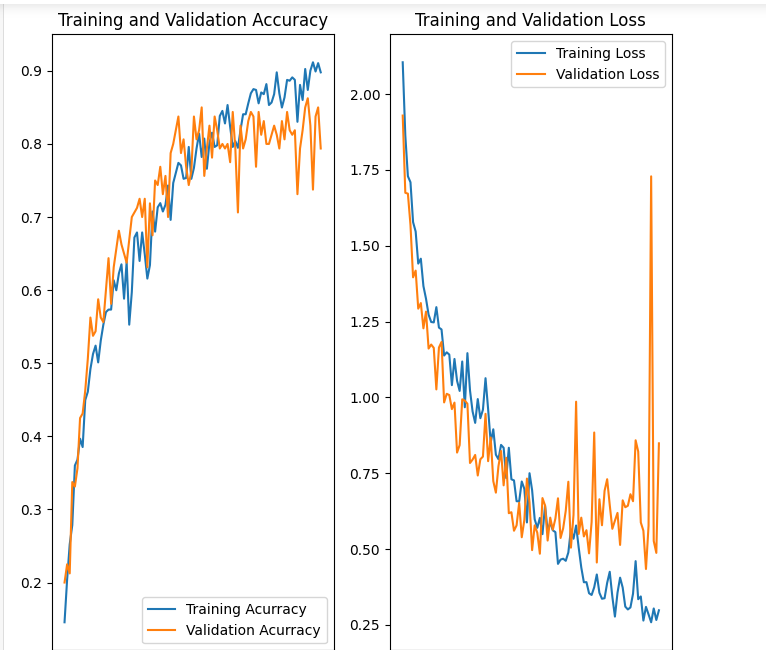

In [24]:
history.params

{'verbose': 1, 'epochs': 75, 'steps': 28}

In [25]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

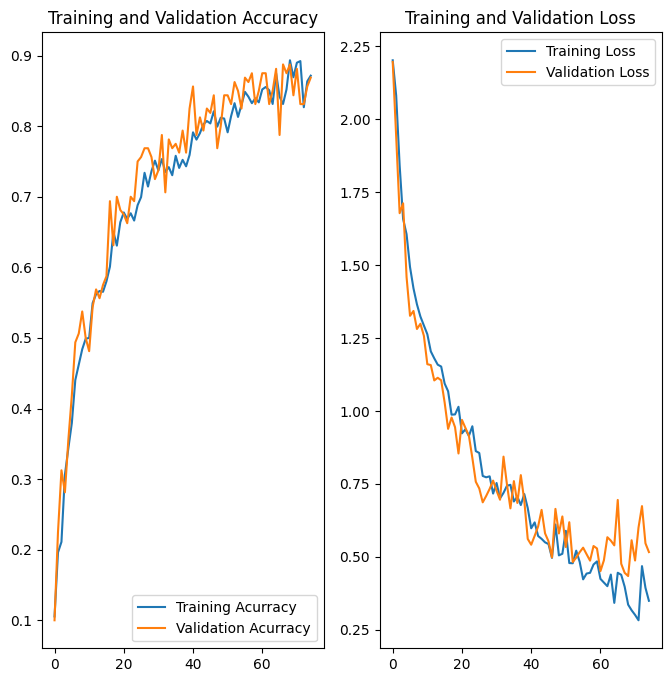

In [27]:
plt.figure(figsize=(8, 8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Acurracy')
plt.plot(range(epochs), val_acc, label='Validation Acurracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

The model seems to be overfitting, but when we applied it to test data, it performed well. The curves in the graphs might suggest that the model is overfitting, but Dropout could cause these curves to appear irregular.

# Test Prediction on sample images

The image is chickoo fruit
1/1 [==============================] - 0s 245ms/step
The prediction of our model is chickoo fruit


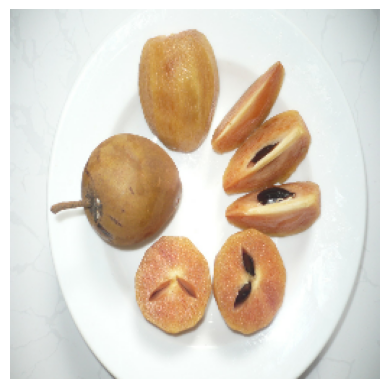

In [28]:
for images_batch, labels_batch in test_ds.take(1):
    
    image = images_batch[0].numpy().astype('uint8')
    label = labels_batch[0].numpy()
    
    print(f"The image is {class_names[label]}")

    plt.imshow(image)
    plt.axis("off")
    
    prediction = model.predict(images_batch)
    print(f"The prediction of our model is {class_names[np.argmax(prediction[0])]}")

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    # just giving in the array like that [256,256,3] we want that way have the batch so if argument 0 hi put a number in front of
    # the actual [256,256,3] so if expand_dims it become [1,256,256,3] equal our input_shape
    img_array = tf.expand_dims(img_array, 0) 
    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 20ms/step


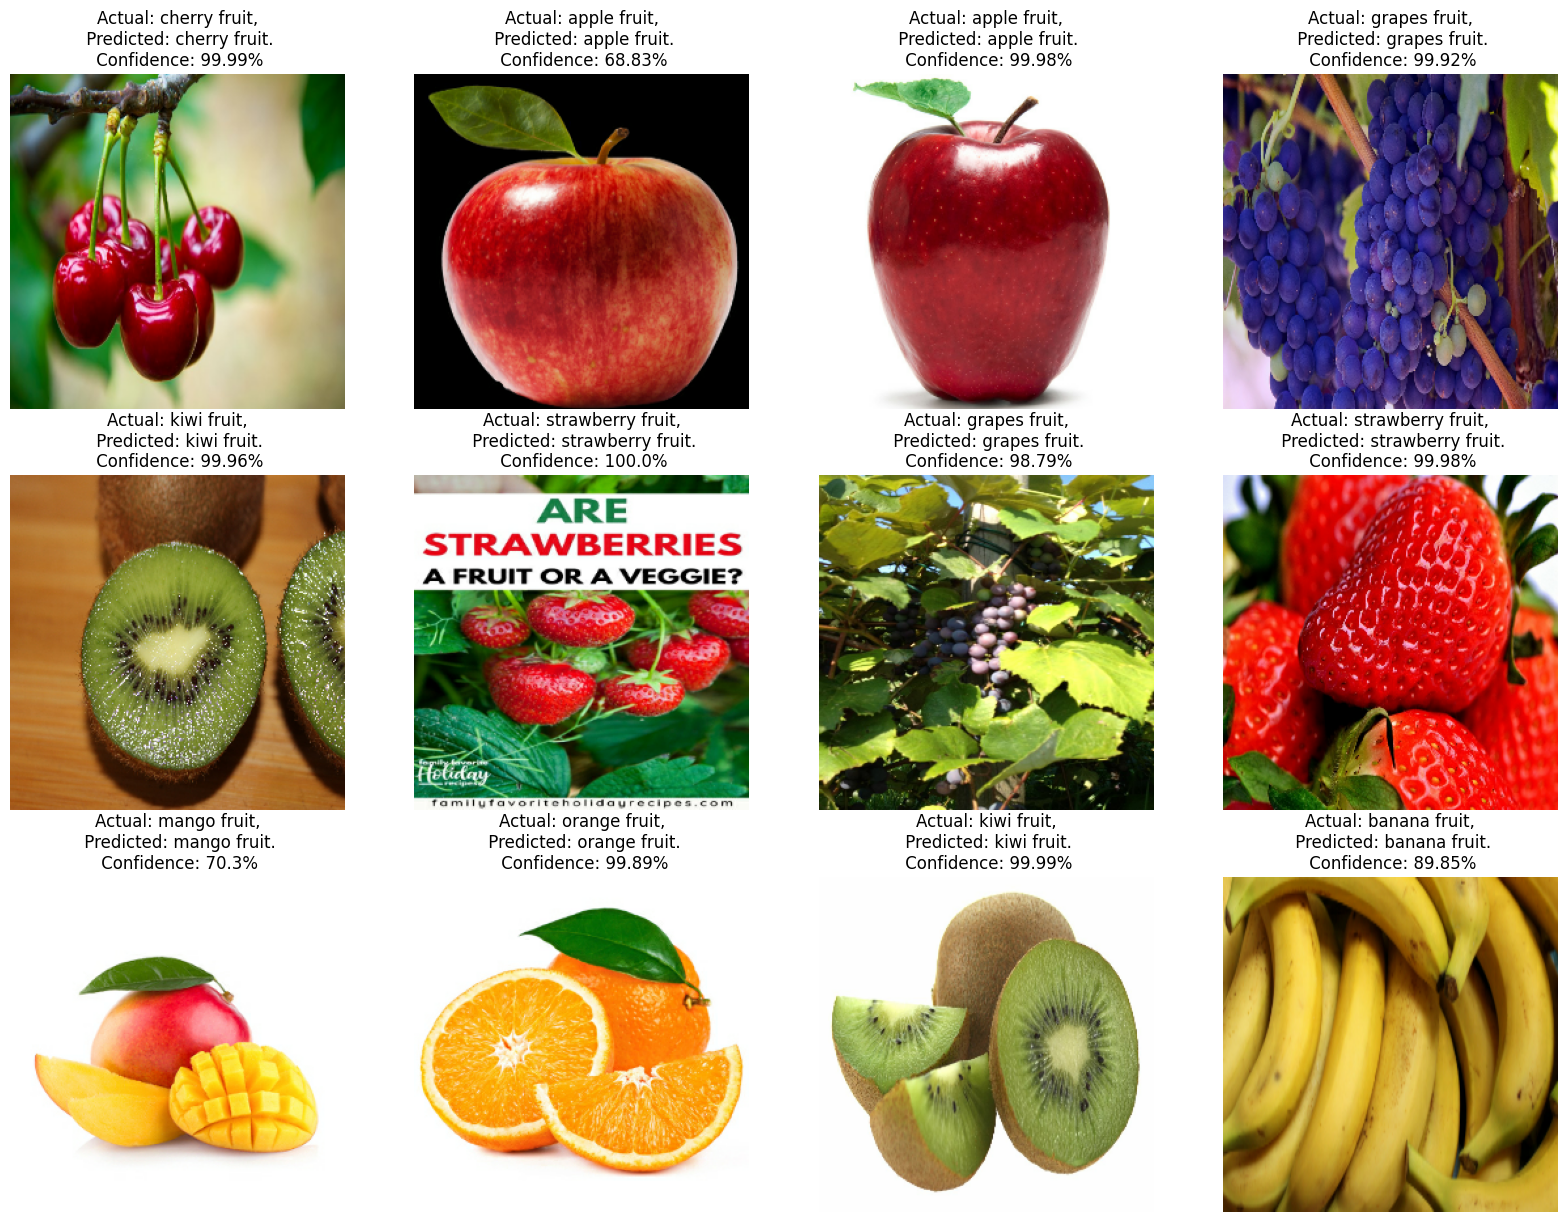

In [30]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

# Saving Model

In [31]:
model_version='Base_Line'
model.save(fr"C:\Users\User\TensorFlowFruits\Model\{model_version}")

INFO:tensorflow:Assets written to: C:\Users\User\TensorFlowFruits\Model\Base_Line\assets


INFO:tensorflow:Assets written to: C:\Users\User\TensorFlowFruits\Model\Base_Line\assets
